# Clustering des causes de retard

In [7]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Data Preparation

In [8]:
data_path = 'data.csv'
data = pd.read_csv(data_path, sep=';')
data['couple_gares'] = [f"{row.gare_depart}-{row.gare_arrivee}" for row in data.itertuples()]
data['retard_parcours'] = (data['retard_moyen_arrivee']-data['retard_moyen_depart'])/data['duree_moyenne']

data.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,couple_gares,retard_parcours
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,...,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336,BORDEAUX ST JEAN-PARIS MONTPARNASSE,0.121907
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,...,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000,LA ROCHELLE VILLE-PARIS MONTPARNASSE,0.113024
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,...,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000,PARIS MONTPARNASSE-QUIMPER,0.209959
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,...,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000,PARIS MONTPARNASSE-ST MALO,0.184042
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,...,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000,PARIS MONTPARNASSE-ST PIERRE DES CORPS,0.075544


In [9]:
data_clustering = data[data['date'].apply(lambda x: x.split('-')[0]) == '2018']

In [10]:
data_clustering = data_clustering.groupby('gare_depart').agg({'prct_cause_externe': 'mean',
                                         'prct_cause_infra': 'mean',
                                         'prct_cause_gestion_trafic': 'mean',
                                         'prct_cause_materiel_roulant': 'mean',
                                         'prct_cause_gestion_gare': 'mean',
                                         'prct_cause_prise_en_charge_voyageurs': 'mean'}).reset_index()

## K-Means fitting on 1 year of data

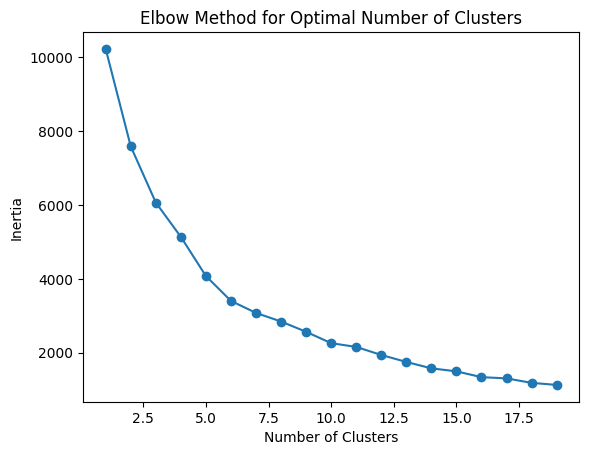

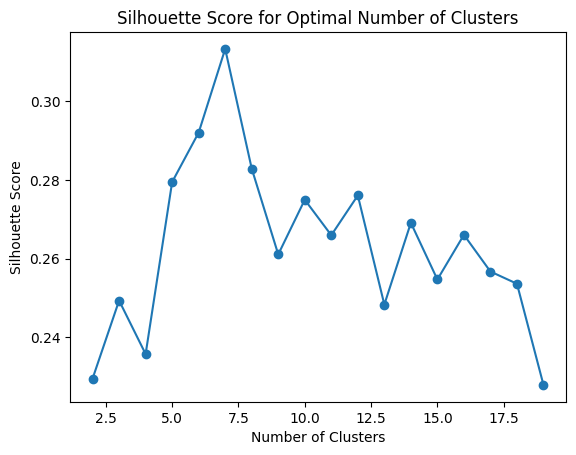

In [11]:
inertia = []

# Define a range of cluster numbers to test
cluster_range = range(1, 20)

# Calculate inertia for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Create an empty list to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to test
cluster_range = range(2, 20)  # Start with a minimum of 2 clusters

# Calculate silhouette scores for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
    silhouette_avg = silhouette_score(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

The elbow rule recommends fitting the KMeans algo on n_clusters = 6 or 7. The Silhouette Score highly recommends n_clusters = 7. -> This will be our ultimate choice.

In [12]:
# Fit k-means on 7 clusters
kmeans = KMeans(n_clusters=7, random_state=0)
cluster_labels = kmeans.fit_predict(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
data_clustering['cluster'] = cluster_labels

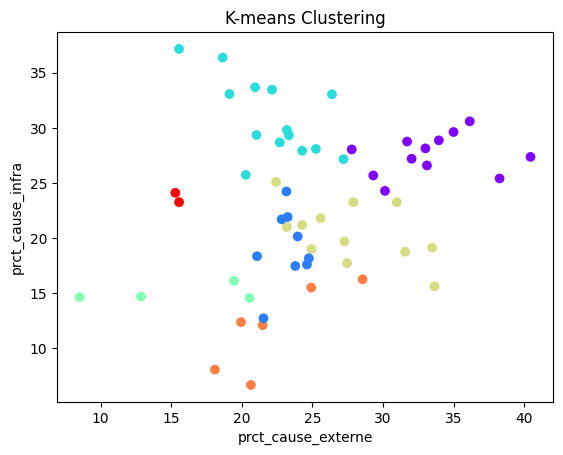

In [13]:
# Plot the data and cluster centers
plt.scatter(data_clustering['prct_cause_externe'], data_clustering['prct_cause_infra'], c=data_clustering['cluster'], cmap='rainbow')
plt.xlabel('prct_cause_externe')
plt.ylabel('prct_cause_infra')
plt.title('K-means Clustering')
plt.show()

In [14]:
cluster_centers = kmeans.cluster_centers_

In [17]:
n_components = 2  # Adjust this to the number of components you need
pca = PCA(n_components=n_components)

# Fit and transform the cluster centroids
cluster_centers_pca = pca.fit_transform(cluster_centers)

# The result, 'cluster_centers_pca', contains the PCA-transformed coordinates of the cluster centroids
print(cluster_centers_pca)

[[-13.30821194  -7.26488961]
 [ -3.71725097   1.09445635]
 [ -2.38132566  -7.77233634]
 [  6.59587661   7.448401  ]
 [  0.13271916  -1.53441061]
 [ -7.31987092  11.73616952]
 [ 19.99806372  -3.70739032]]


In [18]:
new_points = pca.transform(data_clustering[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
new_points_x, new_points_y = new_points[:,0], new_points[:, 1]

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [19]:
data_clustering['projection_x'] = new_points_x
data_clustering['projection_y'] = new_points_y

In [20]:
data_clustering.head()

,gare_depart,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cluster,projection_x,projection_y
0,AIX EN PROVENCE TGV,30.140325,24.277538,16.908954,21.241538,5.036000,2.395645,0,-9.813178,-4.423832
1,ANGERS SAINT LAUD,26.387155,33.034993,18.498349,14.305268,4.687747,3.086487,2,-6.081778,-10.253054
2,ANGOULEME,20.947266,33.677428,20.390078,14.350469,4.554501,6.080258,2,-2.065914,-9.401032
3,ANNECY,30.971833,23.246582,25.669370,14.097670,4.358435,1.656110,4,-1.653072,-4.906241
4,ARRAS,15.296356,24.102809,40.453120,12.556896,6.100829,1.489991,6,18.871609,-3.685619


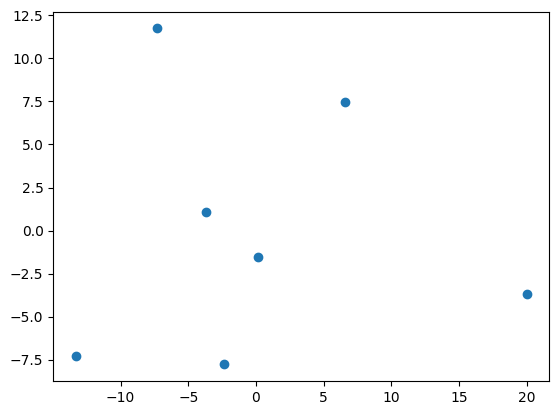

In [21]:
plt.scatter(cluster_centers_pca[:,0], cluster_centers_pca[:, 1])

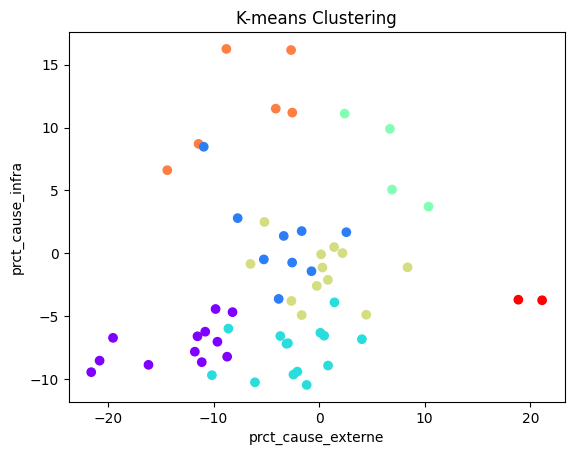

In [22]:
# Plot the data and cluster centers
plt.scatter(data_clustering['projection_x'], data_clustering['projection_y'], c=data_clustering['cluster'], cmap='rainbow')
plt.xlabel('prct_cause_externe')
plt.ylabel('prct_cause_infra')
plt.title('K-means Clustering')
plt.show()